# Advanced analysis with `pandas` and `FloPy`

This exercise, we will load and existing model into Flopy, run the model and then use [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/) and [numpy](https://www.numpy.org/) to look at the results and compare them to observed data. Including:
* reading tabular data from a file or url using the powerful `read_csv` method
* geting `pandas.DataFrame`s of Hydmod, SFR, and global mass balance output
* converting model times to real date-times to allow plotting against other temporally-referenced data
* quickly subsetting data by category, attribute values, times, index position, etc.
* computing quantiles and other basic statistics
* making plots using `matplotlib` and the built-in hooks to it in `pandas`

The example model is a TMR inset of the Little Plover River model set in central WI, which is documented by Bradbury and others (2017). The parent model files and report are avaible [here](https://wgnhs.wisc.edu/little-plover-river-groundwater-model/). The TMR inset encompasses the Little Plover River down to the Hoover Ave. bridge in Plover, WI, and the calendar year of 2014. Unconfined groundwater flow in the underlying glacial outwash, and base flow in the Little Plover River are simulated. Constant heads are used for the perimeter boundaries. The properties are mostly the same as the parent model.

![](../data/lpr_inset/figs/lpr_inset.png)


**Reference:**
Bradbury, K.R., Fienen, M.N., Kniffin, M.L., Krause, J.J., Westenbroek, S.M., Leaf, A.T., and Barlow, P.M., 2017, Groundwater flow model for the Little Plover River basin in Wisconsin’s Central Sands: Wisconsin Geological and Natural History Survey Bulletin 111, 82 p.

In [1]:
import flopy
fm = flopy.modflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

flopy is installed in /Users/aleaf/Documents/GitHub/flopy/flopy


In [2]:
plt.rcParams['figure.figsize'] = (11, 8.5)

### inputs

In [3]:
namefile = 'lpr_inset.nam'
model_ws = '../data/lpr_inset/'
listingfile = '{}/lpr_inset.list'.format(model_ws)
gagefile = '{}/5400625lpr.ggo'.format(model_ws)
start_datetime = '2014-01-01'

gage_data_url = 'https://nwis.waterdata.usgs.gov/wi/nwis/uv?&format=rdb&site_no=05400625&period=&begin_date=2014-01-01&end_date=2014-12-31'

### load the model

In [4]:
m = fm.Modflow.load(namefile, model_ws=model_ws)
m.get_package_list()

['DIS', 'BAS6', 'UPW', 'RCH', 'OC', 'SFR', 'GAGE', 'WEL', 'HYD', 'NWT', 'CHD']

In [5]:
m.exe_name = 'mfnwt'

In [6]:
m

MODFLOW 3 layer(s) 137 row(s) 171 column(s) 12 stress period(s)

### plot the K field in layer 1

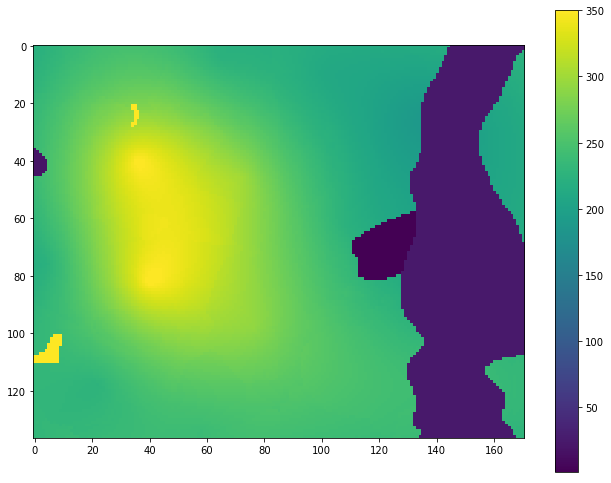

In [7]:
plt.imshow(m.upw.hk.array[0], vmax=350)
plt.colorbar()

### plot recharge for the model period
convert from feet per day to annual inches

In [8]:
m.rch.rech.array.shape

(12, 1, 137, 171)

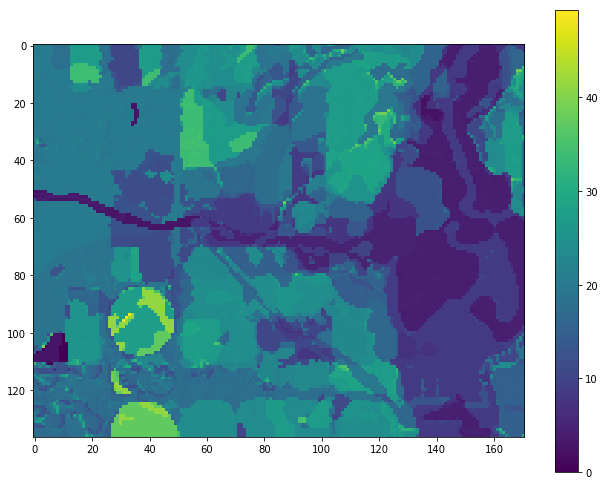

In [9]:
r_in = m.rch.rech.array[:, 0, :, :] * 12
plt.imshow(r_in.sum(axis=0) * 30.4)
plt.colorbar()

### spatial mean of recharge through time
convert from feet per day to average monthly totals (in inches) for model area

<BarContainer object of 12 artists>

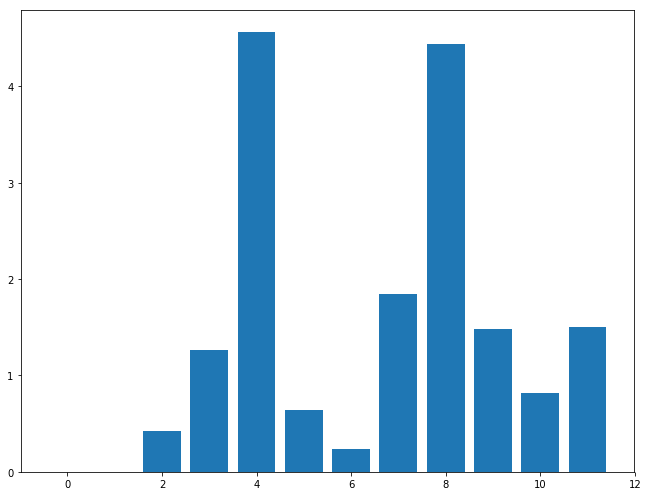

In [10]:
plt.bar(range(12), r_in.mean(axis=(1, 2)) * 30.4)

In [11]:
m.run_model()

FloPy is using the following  executable to run the model: /Users/aleaf/Documents/software/pymake_exes/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: lpr_inset.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/30 17:32:45

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5   

(True, [])

## Looking at results using pandas

#### loading the gage file using `read_csv`

In [12]:
ggo = pd.read_csv(gagefile, skiprows=1, header=None, delim_whitespace=True, names=['time', 'stage', 'flow'])

In [13]:
ggo.head()

,time,stage,flow
0,4.165771,1076.4440,386562.19
1,9.164698,1076.4413,352201.66
2,15.163409,1076.4233,324042.84
3,22.361864,1076.4089,301068.38
4,31.000010,1076.3965,281124.16


#### convert times in gage output to real date times

In [14]:
start_ts = pd.Timestamp(start_datetime)
start_ts

Timestamp('2014-01-01 00:00:00')

In [15]:
pd.to_timedelta(ggo.time, unit='D').head()

0    4 days 03:58:42.657599
1    9 days 03:57:09.872640
2   15 days 03:55:18.537600
3   22 days 08:41:05.049600
4   31 days 00:00:00.864000
Name: time, dtype: timedelta64[ns]

In [16]:
ggo['datetime'] = pd.to_timedelta(ggo.time, unit='D') + start_ts
ggo.index = ggo.datetime
ggo.head()

,time,stage,flow,datetime
datetime,,,,
2014-01-05 03:58:42.657599999,4.165771,1076.4440,386562.19,2014-01-05 03:58:42.657599999
2014-01-10 03:57:09.872640000,9.164698,1076.4413,352201.66,2014-01-10 03:57:09.872640000
2014-01-16 03:55:18.537600000,15.163409,1076.4233,324042.84,2014-01-16 03:55:18.537600000
2014-01-23 08:41:05.049600000,22.361864,1076.4089,301068.38,2014-01-23 08:41:05.049600000
2014-02-01 00:00:00.864000000,31.000010,1076.3965,281124.16,2014-02-01 00:00:00.864000000


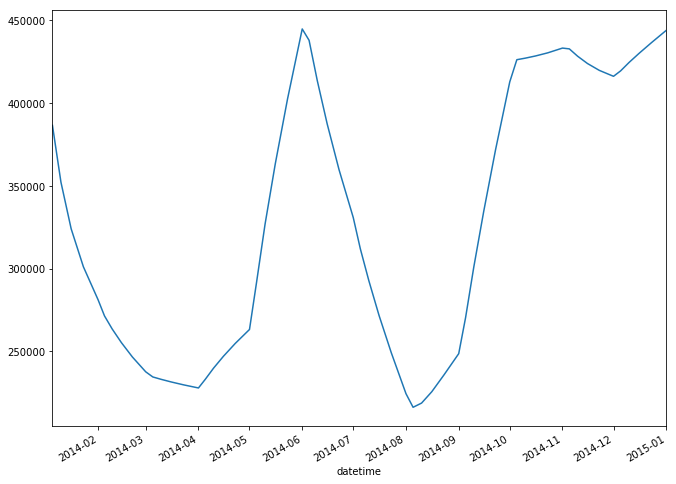

In [17]:
ggo.flow.plot()

### What if we only want to plot flow results for the last timestep of each stress period?

#### make lists of the period and timestep at each row in the gage package output

In [18]:
m.dis.nstp.array

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [19]:
kstp = []
kper = []
for i, nstp in enumerate(m.dis.nstp.array):
    for j in range(nstp):
        kstp.append(j)
        kper.append(i)
len(kstp)

60

In [20]:
ggo['kstp'] = kstp
ggo['kper'] = kper
ggo.head()

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-01-05 03:58:42.657599999,4.165771,1076.4440,386562.19,2014-01-05 03:58:42.657599999,0,0
2014-01-10 03:57:09.872640000,9.164698,1076.4413,352201.66,2014-01-10 03:57:09.872640000,1,0
2014-01-16 03:55:18.537600000,15.163409,1076.4233,324042.84,2014-01-16 03:55:18.537600000,2,0
2014-01-23 08:41:05.049600000,22.361864,1076.4089,301068.38,2014-01-23 08:41:05.049600000,3,0
2014-02-01 00:00:00.864000000,31.000010,1076.3965,281124.16,2014-02-01 00:00:00.864000000,4,0


### Get the last timesteps using `groupby`

In [21]:
ggo_last = ggo.groupby(ggo.kper).last()
ggo_last.index = ggo_last.datetime
ggo_last

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-02-01 00:00:00.864000000,31.000010,1076.3965,281124.16,2014-02-01 00:00:00.864000000,4,0
2014-03-01 00:00:01.641600000,59.000019,1076.3673,237598.84,2014-03-01 00:00:01.641600000,4,1
2014-04-01 00:00:02.678400000,90.000031,1076.3594,227836.59,2014-04-01 00:00:02.678400000,4,2
2014-05-01 00:00:04.320000000,120.000050,1076.3799,263181.75,2014-05-01 00:00:04.320000000,4,3
2014-06-01 00:00:05.184000000,151.000060,1076.4760,444835.75,2014-06-01 00:00:05.184000000,4,4
2014-07-01 00:00:06.912000000,181.000080,1076.4280,330844.44,2014-07-01 00:00:06.912000000,4,5
2014-08-01 00:00:07.776000000,212.000090,1076.3630,224375.64,2014-08-01 00:00:07.776000000,4,6
2014-09-01 00:00:10.368000000,243.000120,1076.3694,248576.41,2014-09-01 00:00:10.368000000,4,7
2014-10-01 00:00:10.368000000,273.000120,1076.4595,412836.50,2014-10-01 00:00:10.368000000,4,8


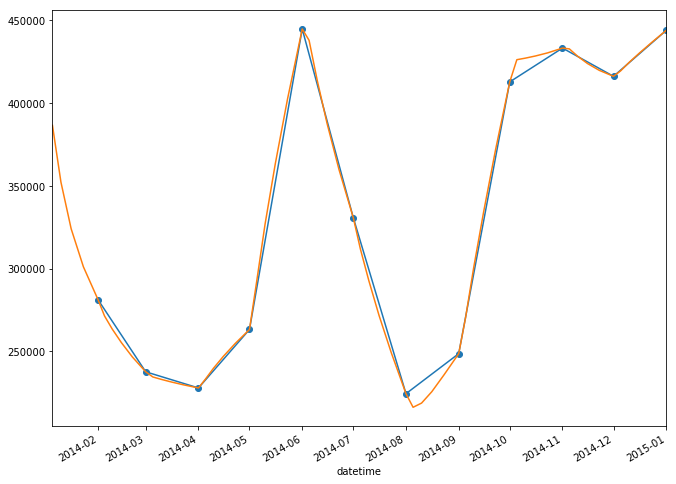

In [22]:
ax = ggo_last.flow.plot(marker='o')
ggo.flow.plot(ax=ax)

Some Flopy utilities can return model results in DataFrames.

### Get model mass balance information from the listing file

In [23]:
from flopy.utils import MfListBudget

In [24]:
mfl = MfListBudget('{}/{}.list'.format(model_ws, m.name))

In [25]:
df_flux, df_vol = mfl.get_dataframes(start_datetime='01-01-2014')

In [26]:
df_flux.head()

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,RECHARGE_IN,STREAM_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,RECHARGE_OUT,STREAM_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2014-02-01,426492.531250,646987.50,0.0,4.471989e+02,555.530823,1074482.75,0.000000e+00,394497.12500,81550.476562,0.0,598601.3750,1074649.000,-166.250,-0.02
2014-03-01,483468.968750,616617.25,0.0,4.410000e+02,1439.527954,1101966.75,0.000000e+00,502048.37500,71357.640625,0.0,528673.3125,1102079.250,-112.500,-0.01
2014-04-01,198845.359375,620831.25,0.0,2.617255e+05,1598.824097,1083001.00,1.075370e+03,494819.87500,73988.679688,0.0,513919.3125,1083803.250,-802.250,-0.07
2014-05-01,13266.372070,635002.00,0.0,7.910498e+05,669.892822,1439988.00,4.185639e+05,384565.34375,69679.789062,0.0,567054.5625,1439863.625,124.375,0.01
2014-06-01,0.000000,1154975.75,0.0,2.851267e+06,0.000000,4006242.75,2.526834e+06,307455.46875,303679.531250,0.0,868731.3750,4006700.000,-457.250,-0.01


### plot some of the components against gage output

If we want to have more control over a plot, it often makes sense to use `matplotlib.pyplot` instead of the `DataFrame.plot()` methods.

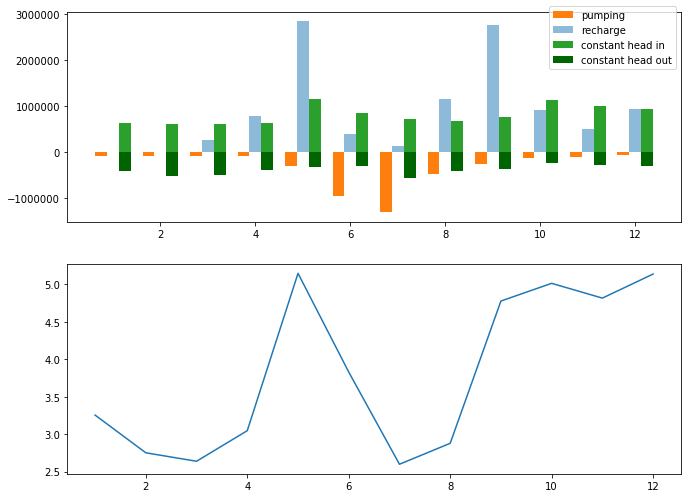

In [27]:
nbars = 2
width = 1/(nbars+2)
xvalues = np.arange(12)+1

fig, axes = plt.subplots(2, 1)
ax = axes.flat[0]
ax.bar(xvalues-width, -df_flux.WELLS_OUT, width=width, label='pumping', color='C1')
ax.bar(xvalues, df_flux.RECHARGE_IN, width=width, label='recharge', color='C0', alpha=0.5)
ax.bar(xvalues+width, df_flux.CONSTANT_HEAD_IN, width=width, label='constant head in', color='C2')
ax.bar(xvalues+width, -df_flux.CONSTANT_HEAD_OUT, width=width, label='constant head out', color='DarkGreen')

ax2 = axes.flat[1]
ax2.plot(xvalues, ggo_last.flow/86400)
ax.legend(bbox_to_anchor=(1., 1.05))

### Compare gage output to actual gage data from the web

In [28]:
gage_data_url

'https://nwis.waterdata.usgs.gov/wi/nwis/uv?&format=rdb&site_no=05400625&period=&begin_date=2014-01-01&end_date=2014-12-31'

### get data for site 5400625 in rdb format, using `read_csv`

In [29]:
df = pd.read_csv(gage_data_url, skiprows=30, header=None, sep='\t')
df.head()

,0,1,2,3,4,5
0,USGS,5400625,2014-03-18 00:00,CDT,1.91,A
1,USGS,5400625,2014-03-18 00:15,CDT,1.98,A
2,USGS,5400625,2014-03-18 00:30,CDT,1.98,A
3,USGS,5400625,2014-03-18 00:45,CDT,1.98,A
4,USGS,5400625,2014-03-18 01:00,CDT,1.98,A


### convert times to pandas datetimes

flow values are in column 4 in cubic feet per second

In [30]:
df.index = pd.to_datetime(df[2])
df.head()

,0,1,2,3,4,5
2,,,,,,
2014-03-18 00:00:00,USGS,5400625,2014-03-18 00:00,CDT,1.91,A
2014-03-18 00:15:00,USGS,5400625,2014-03-18 00:15,CDT,1.98,A
2014-03-18 00:30:00,USGS,5400625,2014-03-18 00:30,CDT,1.98,A
2014-03-18 00:45:00,USGS,5400625,2014-03-18 00:45,CDT,1.98,A
2014-03-18 01:00:00,USGS,5400625,2014-03-18 01:00,CDT,1.98,A


### convert monthly gage package results to cfs

In [31]:
ggo_last['flow_cfs'] = ggo_last['flow'] / 86400
ggo_last.head()

,time,stage,flow,datetime,kstp,kper,flow_cfs
datetime,,,,,,,
2014-02-01 00:00:00.864000,31.000010,1076.3965,281124.16,2014-02-01 00:00:00.864000,4,0,3.253752
2014-03-01 00:00:01.641600,59.000019,1076.3673,237598.84,2014-03-01 00:00:01.641600,4,1,2.749987
2014-04-01 00:00:02.678400,90.000031,1076.3594,227836.59,2014-04-01 00:00:02.678400,4,2,2.636998
2014-05-01 00:00:04.320000,120.000050,1076.3799,263181.75,2014-05-01 00:00:04.320000,4,3,3.046085
2014-06-01 00:00:05.184000,151.000060,1076.4760,444835.75,2014-06-01 00:00:05.184000,4,4,5.148562


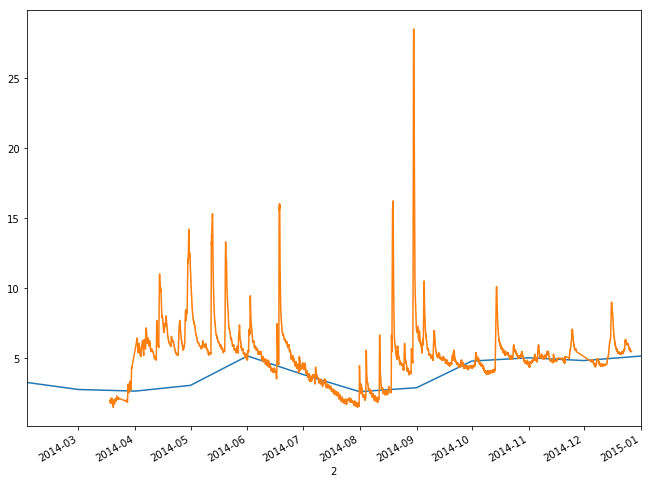

In [32]:
ax = ggo_last.flow_cfs.plot()
df[4].plot()

### convert gage results to monthly averages for flows less than q threshold

align timestamps with gage results

In [33]:
qthresh = 0.5
quant = df[4].quantile(qthresh)
quant

5.01

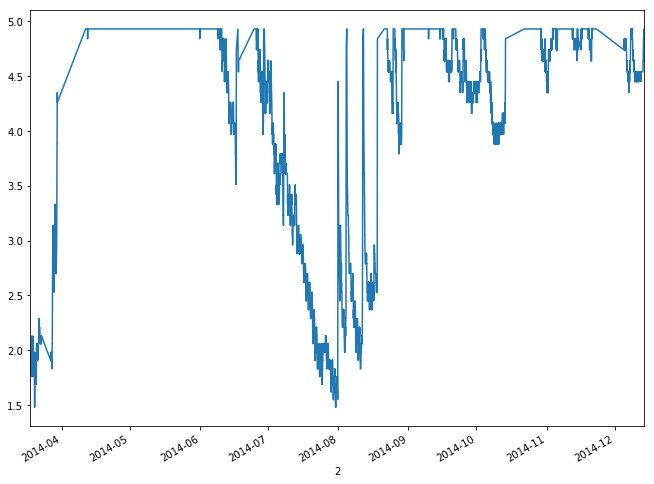

In [34]:
df[4].loc[df[4] < quant].plot()

In [35]:
dfq = df[4].loc[df[4] < quant]
dfm = dfq.groupby(dfq.index.month).mean()
dfm

2
3     2.260339
4     4.915306
5     4.905172
6     4.474170
7     2.821630
8     3.088166
9     4.568209
10    4.378487
11    4.787361
12    4.620000
Name: 4, dtype: float64

### create end of month times for monthly gage data averages so they plot with gage package output

In [36]:
start_ts

Timestamp('2014-01-01 00:00:00')

In [37]:
pd.date_range('2014-03', '2014-12', freq='M')

DatetimeIndex(['2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30'],
              dtype='datetime64[ns]', freq='M')

In [38]:
dfm.index = pd.date_range('2014-03', '2015-01', freq='M')
dfm

2014-03-31    2.260339
2014-04-30    4.915306
2014-05-31    4.905172
2014-06-30    4.474170
2014-07-31    2.821630
2014-08-31    3.088166
2014-09-30    4.568209
2014-10-31    4.378487
2014-11-30    4.787361
2014-12-31    4.620000
Freq: M, Name: 4, dtype: float64

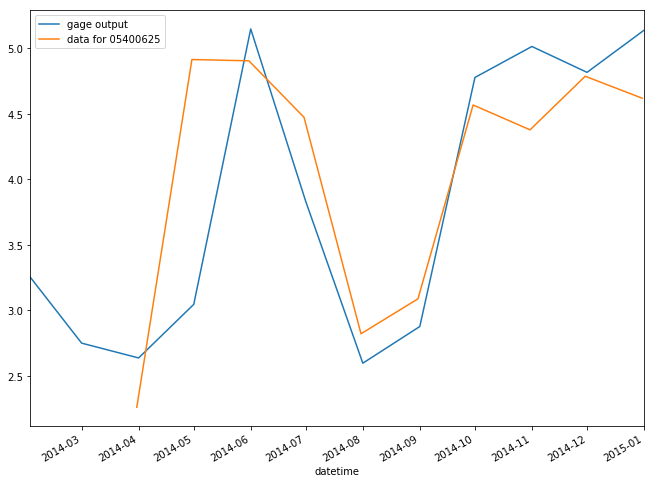

In [39]:
ax = ggo_last.flow_cfs.plot(label='gage output')
dfm.plot(ax=ax, label='data for 05400625')
ax.legend()

In [40]:
dfm

2014-03-31    2.260339
2014-04-30    4.915306
2014-05-31    4.905172
2014-06-30    4.474170
2014-07-31    2.821630
2014-08-31    3.088166
2014-09-30    4.568209
2014-10-31    4.378487
2014-11-30    4.787361
2014-12-31    4.620000
Freq: M, Name: 4, dtype: float64

In [41]:
ggo_last

,time,stage,flow,datetime,kstp,kper,flow_cfs
datetime,,,,,,,
2014-02-01 00:00:00.864000000,31.000010,1076.3965,281124.16,2014-02-01 00:00:00.864000000,4,0,3.253752
2014-03-01 00:00:01.641600000,59.000019,1076.3673,237598.84,2014-03-01 00:00:01.641600000,4,1,2.749987
2014-04-01 00:00:02.678400000,90.000031,1076.3594,227836.59,2014-04-01 00:00:02.678400000,4,2,2.636998
2014-05-01 00:00:04.320000000,120.000050,1076.3799,263181.75,2014-05-01 00:00:04.320000000,4,3,3.046085
2014-06-01 00:00:05.184000000,151.000060,1076.4760,444835.75,2014-06-01 00:00:05.184000000,4,4,5.148562
2014-07-01 00:00:06.912000000,181.000080,1076.4280,330844.44,2014-07-01 00:00:06.912000000,4,5,3.829218
2014-08-01 00:00:07.776000000,212.000090,1076.3630,224375.64,2014-08-01 00:00:07.776000000,4,6,2.596940
2014-09-01 00:00:10.368000000,243.000120,1076.3694,248576.41,2014-09-01 00:00:10.368000000,4,7,2.877042
2014-10-01 00:00:10.368000000,273.000120,1076.4595,412836.50,2014-10-01 00:00:10.368000000,4,8,4.778200


## Hydmod

In [42]:
from flopy.utils import HydmodObs

In [43]:
hydobj = HydmodObs('{}/{}.hyd.bin'.format(m.model_ws, m.name))
hyd = pd.DataFrame(hydobj.get_data())
hyd.head()

,totim,HDI00100910042_uwsp,HDI00200910042_uwsp,HDI00300910042_uwsp,HDI00100940041_uwsp,HDI00200940041_uwsp,HDI00300940041_uwsp,HDI0012309e1803_uwsp,HDI0022309e1803_uwsp,HDI0032309e1803_uwsp,...,HDI0032900089303001,HDI0012908089294701,HDI0022908089294701,HDI0032908089294701,HDI0012909089311801,HDI0022909089311801,HDI0032909089311801,HDI0012915089302001,HDI0022915089302001,HDI0032915089302001
0,0.000000,1076.331665,1076.324951,1076.324951,1074.555908,1074.627930,1074.627930,1077.633057,1077.529053,1077.529053,...,1075.167480,1076.731567,1076.729126,1076.729126,1073.711182,1073.710938,1073.710938,1075.585571,1075.584961,1075.584961
1,4.165771,1076.173828,1076.160034,1076.159546,1074.567261,1074.649658,1074.652466,1077.837646,1077.839600,1077.839600,...,1075.188965,1076.689819,1076.683472,1076.683228,1073.570679,1073.551636,1073.550903,1075.552734,1075.546265,1075.546021
2,9.164698,1076.102295,1076.097534,1076.097290,1074.571899,1074.650879,1074.653564,1077.921875,1077.915771,1077.915527,...,1075.169312,1076.648071,1076.643066,1076.642822,1073.514282,1073.504883,1073.504517,1075.498779,1075.492676,1075.492432
3,15.163409,1076.072510,1076.071411,1076.071411,1074.565063,1074.640869,1074.643433,1077.928833,1077.916748,1077.916382,...,1075.138184,1076.591431,1076.585815,1076.585693,1073.491211,1073.483887,1073.483521,1075.436646,1075.430664,1075.430420
4,22.361864,1076.058350,1076.058472,1076.058472,1074.549561,1074.622192,1074.624634,1077.895264,1077.880981,1077.880493,...,1075.096436,1076.515991,1076.510132,1076.509888,1073.474487,1073.467285,1073.467041,1075.366211,1075.360474,1075.360229


## Look at SFR water balance output (time pending)

In [44]:
from flopy.utils import SfrFile

In [45]:
sfrobj = SfrFile('{}/{}.sfr.out'.format(m.model_ws, m.name))

### get dataframe of SFR results

In [46]:
sfrdata = sfrobj.df.copy()

In [47]:
sfrdata.head()

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,col16,kstpkper,k,i,j
0,1,64,119,1,1,0.00,-574.790,574.79,0.0,0.0,0.0,1087.15,0.04736,0.6774,163.20,-3.914,"(4, 0)",0,63,118
1,1,64,118,1,2,574.79,-78.274,653.06,0.0,0.0,0.0,1087.10,0.03677,0.7416,22.99,-3.783,"(4, 0)",0,63,117
2,1,63,118,1,3,653.06,-1146.900,1800.00,0.0,0.0,0.0,1087.12,0.09642,0.8419,331.10,-3.848,"(4, 0)",0,62,117
3,1,63,117,1,4,1800.00,-907.060,2707.00,0.0,0.0,0.0,1087.09,0.11940,1.0010,278.30,-3.622,"(4, 0)",0,62,116
4,1,63,116,1,5,2707.00,-962.420,3669.50,0.0,0.0,0.0,1087.05,0.13740,1.1320,314.50,-3.400,"(4, 0)",0,62,115


### plot the groundwater/surfacewater interactions for a segment

get the distance information from the SFR package input

In [48]:
seg11 = sfrdata.loc[(sfrdata.segment == 11) & (sfrdata.kstpkper == (4, 6)), ['Qout', 'Qaquifer']]

# get the reach data for SFR package
rd = pd.DataFrame(m.sfr.reach_data)
rd.head()

,node,k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1,thts,thti,eps,uhc,reachID,outreach
0,10891,0,63,118,1,1,86.921516,1087.099976,0.000389,0.9,2.493963,0.0,0.0,0.0,0.0,1,2
1,10890,0,63,117,1,2,11.187760,1087.066040,0.003443,0.9,2.493963,0.0,0.0,0.0,0.0,2,3
2,10719,0,62,117,1,3,141.945404,1087.027954,0.000429,0.9,2.493963,0.0,0.0,0.0,0.0,3,4
3,10718,0,62,116,1,4,100.375504,1086.967041,0.000503,0.9,2.493963,0.0,0.0,0.0,0.0,4,5
4,10717,0,62,115,1,5,100.273300,1086.916016,0.000493,0.9,2.493963,0.0,0.0,0.0,0.0,5,6


In [49]:
dist = rd.loc[rd.iseg == 11, 'rchlen'].cumsum().tolist()
dist[0:10]

[117.24130249023438,
 130.0492706298828,
 176.3160858154297,
 231.3611602783203,
 332.6730651855469,
 394.13525390625,
 445.6619873046875,
 554.2612915039062,
 654.5363159179688,
 756.0889282226562]

In [50]:
seg11.index = dist

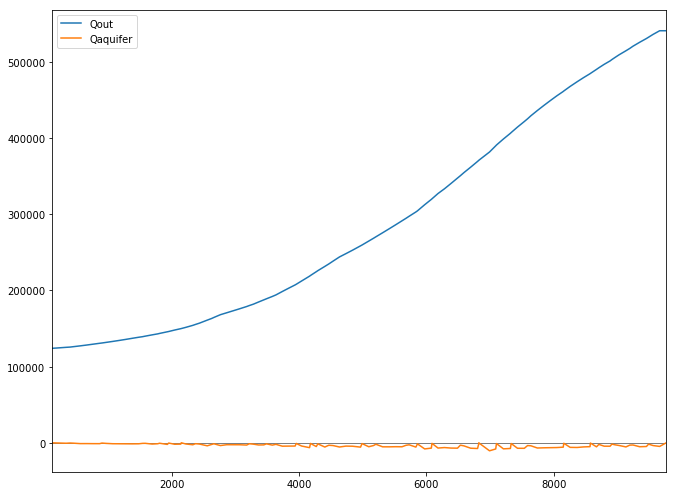

In [51]:
ax = seg11.plot()
ax.axhline(0, color='k', zorder=-1, lw=0.5)

### make a quick and dirty map of groundwater/surface water interactions

In [52]:
arr = np.zeros((m.nrow, m.ncol), dtype=float) * np.nan

i = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'i']
j = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'j']
qgw = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'Qaquifer']
arr[i, j] = qgw

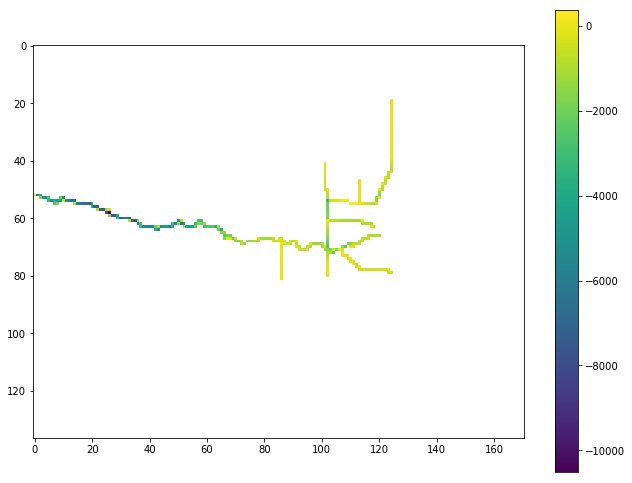

In [53]:
plt.imshow(arr)
plt.colorbar()

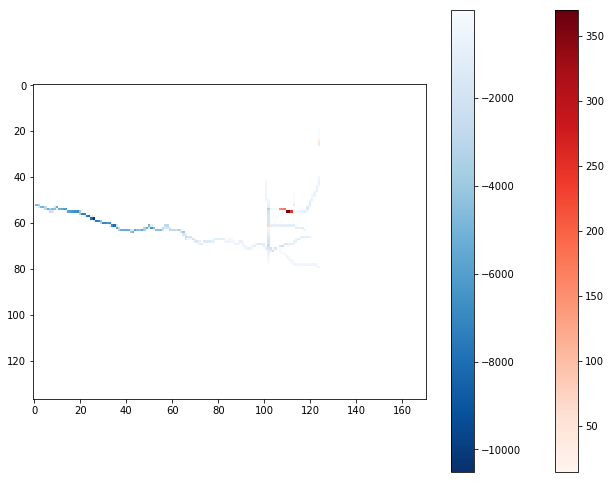

In [54]:
losing = arr.copy()
losing[losing <= 0] = np.nan
gaining = arr.copy()
gaining[gaining >= 0] = np.nan
im = plt.imshow(losing, cmap='Reds')
im2 = plt.imshow(gaining, cmap='Blues_r')
plt.colorbar(im)
plt.colorbar(im2)